## FDS Project - Stock Buddy

#### This project aims to guide people with less knowledge in stock market or companies to make smart investment choices.

In [1]:
# Importing libraries used

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
import statsmodels.api as sm
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
from scipy.optimize import minimize
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
import requests
from io import StringIO
from fredapi import Fred
from sklearn.metrics import mean_squared_error
import sklearn
from IPython.display import Javascript

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv")

### What sector companies are you interested in? Please choose from below options:

In [3]:
for item in data['Sector'].unique():
    print(item)
sector = input('Enter the interested sector from available options: ')

Industrials
Health Care
Information Technology
Communication Services
Consumer Staples
Consumer Discretionary
Utilities
Financials
Materials
Real Estate
Energy
Enter the interested sector from available options: Health Care


### Here are the options you have from that sector:

In [4]:
for item in data[data['Sector'] == sector]['Name']:
    print(item)
names = input("Enter your companies that you want to invest: ")

Abbott Laboratories
AbbVie
Abiomed
Agilent Technologies
Align Technology
AmerisourceBergen
Amgen
Anthem
Baxter International
Becton Dickinson
Bio-Rad Laboratories
Bio-Techne
Biogen
Boston Scientific
Bristol Myers Squibb
Cardinal Health
Catalent
Centene Corporation
Cerner
Charles River Laboratories
Cigna
CVS Health
Danaher Corporation
DaVita
Dentsply Sirona
DexCom
Edwards Lifesciences
Eli Lilly & Co
Gilead Sciences
HCA Healthcare
Henry Schein
Hologic
Humana
Idexx Laboratories
Illumina
Incyte
Intuitive Surgical
IQVIA
Johnson & Johnson
LabCorp
McKesson Corporation
Medtronic
Merck & Co.
Mettler Toledo
Moderna
Organon & Co.
PerkinElmer
Pfizer
Quest Diagnostics
Regeneron Pharmaceuticals
ResMed
Steris
Stryker Corporation
Teleflex
The Cooper Companies
Thermo Fisher Scientific
UnitedHealth Group
Universal Health Services
Vertex Pharmaceuticals
Viatris
Waters Corporation
West Pharmaceutical Services
Zimmer Biomet
Zoetis
Enter your companies that you want to invest: moderna,stryker


In [5]:
stocks = names.split(',')
sym = []
for i in stocks:
    d = data.loc[data['Name'].str.contains(i, case = False)]
    a = d.values.tolist()
    symb = a[0][0]
    sym.append(symb)

stocks = sym
stock_len = len(stocks)
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,10,1)
stock_data = yf.download(stocks, start = start, end=end, interval='1d')['Close']

[*********************100%***********************]  2 of 2 completed


In [6]:
exp_ret1 = int(input('How much % return are you expecting from the companies: '))
exp_ret = exp_ret1/10000

How much % return are you expecting from the companies: 10


In [7]:
# # #https://stackoverflow.com/questions/47567834/execute-a-jupyter-notebook-cell-programmatically
# Javascript("Jupyter.notebook.execute_cell_range(9,66)")

### Here's how your selected stocks are looking like:

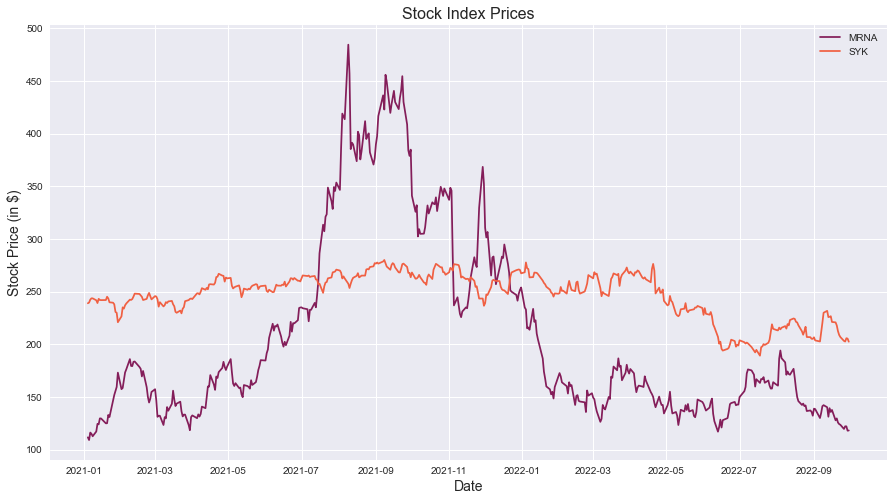

In [8]:
# Plotting stock price movements across the dates

fig, ax = plt.subplots(figsize = ( 15 , 8 ))
palette = sns.color_palette("rocket", stock_len)
graph_1 = sns.lineplot(data=stock_data, dashes=False, palette=palette)
ax.set_xlabel( "Date" , size = 14 )
ax.set_ylabel( "Stock Price (in $)" , size = 14 )
ax.set_title( "Stock Index Prices" , size = 16 )
plt.show()

### Here are the basic stats of companies selected:

In [9]:
# Calculate returns

returns = np.log(stock_data/stock_data.shift(1))
returns.dropna(inplace=True)
returns.describe()

,MRNA,SYK
count,439.000000,439.000000
mean,0.000129,-0.000377
std,0.048615,0.016330
min,-0.197163,-0.083855
25%,-0.028683,-0.009141
50%,-0.001894,-0.000381
75%,0.030721,0.008861
max,0.187071,0.047915


### First, focusing on individual companies:

In [10]:
sym.append('^GSPC')

# Getting data using yfinance API
companies = sym # Specifying company names
companies_len = len(companies)
start_date = datetime.datetime(2021, 1, 1) # Specifying start date of required stock prices
end_date = datetime.datetime(2022, 10, 1) # Specifying end date of required stock prices
data = yf.download(companies, start=start_date, end=end_date, interval='1d') # Calling API

df = data['Close'] # Specifying 'Close' as we would only be working with closing prices
df = df.rename({'^GSPC':'GSPC'}, axis='columns')
df.dropna(inplace=True) # Dropping null values

# Calculating stock returns

stock_return = df.pct_change() # Using percentage change method to do so
stock_return.dropna(inplace=True)

[*********************100%***********************]  3 of 3 completed


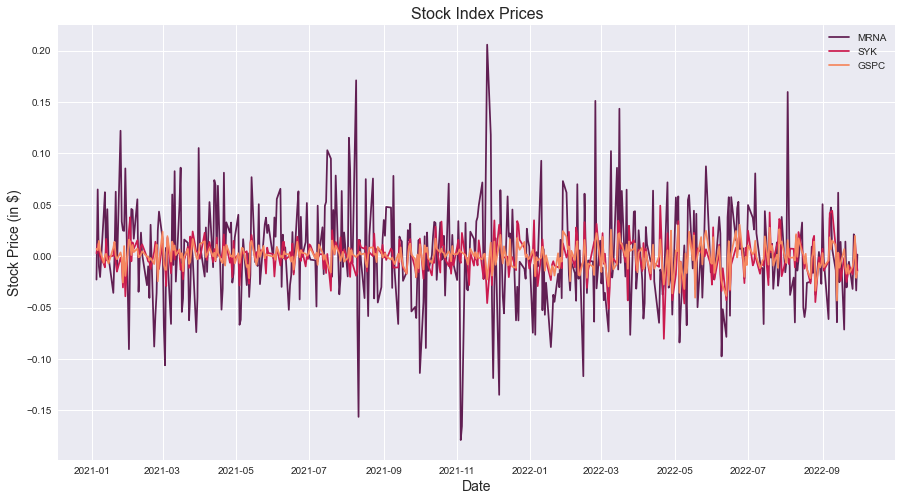

In [11]:
# Plotting stock price movements across the dates

fig, ax = plt.subplots(figsize = ( 15 , 8 ))
palette = sns.color_palette("rocket", companies_len)
graph_1 = sns.lineplot(data=stock_return, dashes=False, palette=palette)
ax.set_xlabel( "Date" , size = 14 )
ax.set_ylabel( "Stock Price (in $)" , size = 14 )
ax.set_title( "Stock Index Prices" , size = 16 )
plt.show()

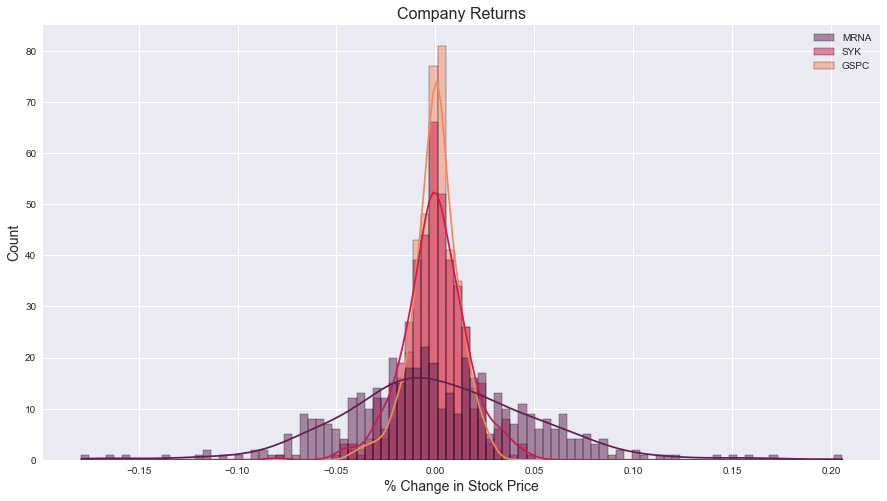

In [12]:
# Plotting histogram of stock returns for companies

fig, ax = plt.subplots(figsize = ( 15 , 8 ))
palette = sns.color_palette("rocket", companies_len)
sns.histplot(data = stock_return, kde=True, palette=palette)
ax.set_xlabel( "% Change in Stock Price" , size = 14 )
ax.set_ylabel( "Count" , size = 14 )
ax.set_title( "Company Returns" , size = 16 )
plt.show()

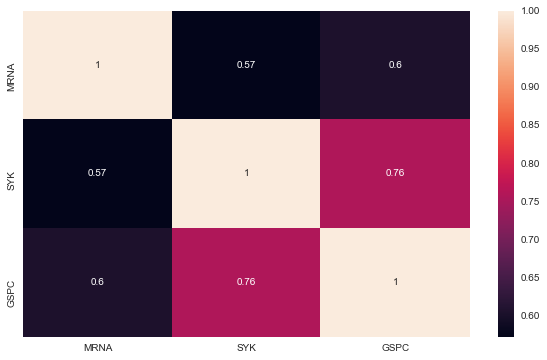

In [13]:
# Plotting correlation coefficient between companies

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot = True)
plt.show()

### Applying CAPM to get expected annual returns:

In [14]:
# Importing statsmodel library

import statsmodels.api as sm

# Searching for the different risk free indexes available in FRED

from fredapi import Fred
fred = Fred(api_key='3b3195d2d68eb46fe279c604e9026d89')
fred_df = fred.search('risk free')

risk_free = fred.get_series('DGS2')
risk_free = risk_free['2021-01-01':'2022-10-01']
# risk_free = risk_free / 100
risk_free = risk_free / 730
risk_free = risk_free.dropna().iloc[:-1]

# Calculating the excess returns for our companies
symbol = sym[:-1]
symbol.append("GSPC")
stocks = symbol
for i in stocks:
    stock_return[f"excess_return_{i}"] = stock_return[i] - risk_free

retun = stock_return.loc[:,['excess_return_' in i for i in stock_return.columns]]
new_stock_return = stock_return.loc[:,['excess_return_' in i for i in stock_return.columns]]

# Assigning x

X = new_stock_return['excess_return_GSPC']

if X.isna().sum() != 0:
    X.dropna(inplace=True)

betas = []
for i in range(new_stock_return.shape[1]):
    y_stocks = new_stock_return.iloc[:, i]
    if y_stocks.isna().sum() != 0:
        y_stocks.dropna(inplace=True)
    X = sm.add_constant(X, prepend=False)
    CAPM_stocks = sm.OLS(y_stocks, X)
    CAPM_results_stocks = CAPM_stocks.fit()
    
    print('\n')
    print('**********************************************************************************************')
    print('\n')
    print(CAPM_results_stocks.summary())
    beta = CAPM_results_stocks.params[0]
    betas.append(beta)



**********************************************************************************************


                            OLS Regression Results                            
Dep. Variable:     excess_return_MRNA   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     51.72
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           2.83e-12
Time:                        12:24:17   Log-Likelihood:                 721.65
No. Observations:                 436   AIC:                            -1439.
Df Residuals:                     434   BIC:                            -1431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------

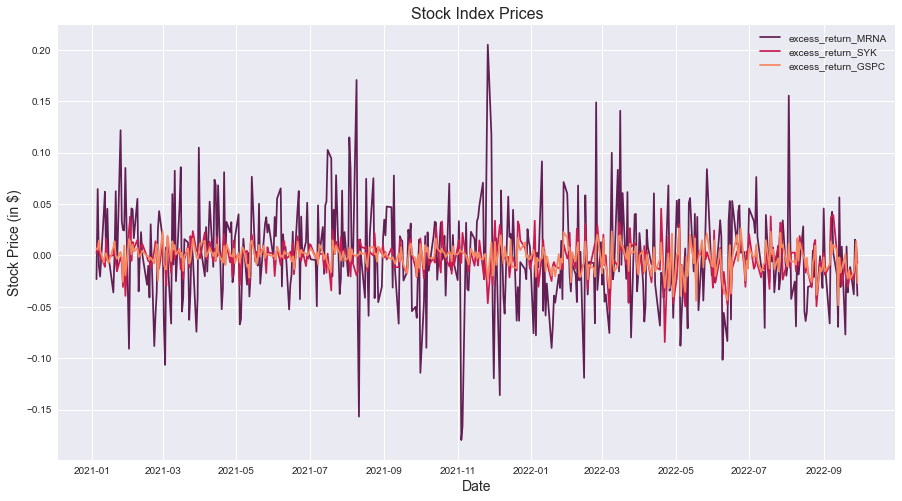

In [15]:
# Plotting stock price movements across the dates

fig, ax = plt.subplots(figsize = ( 15 , 8 ))
palette = sns.color_palette("rocket", companies_len)
graph_1 = sns.lineplot(data=new_stock_return, dashes=False, palette=palette)
ax.set_xlabel( "Date" , size = 14 )
ax.set_ylabel( "Stock Price (in $)" , size = 14 )
ax.set_title( "Stock Index Prices" , size = 16 )
plt.show()

### Accessing the risk for an expected return:

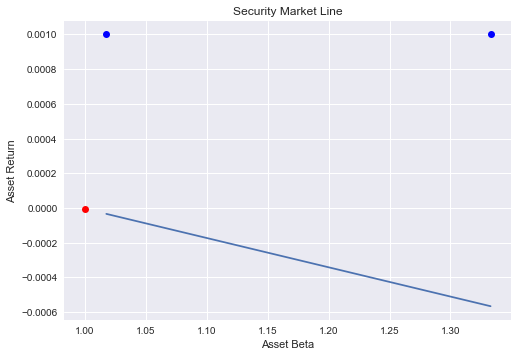

In [16]:
# Importing matplotlib

import matplotlib.pyplot as plt

# Defining the Security Market Line function
# rf:risk_free rate
# ret:return
# rm:market return

def SML(rf,rm,ret,betas):
    asset_ret = [rf + (rm - rf) * i for i in betas]
    plt.plot(betas, asset_ret)
    plt.xlabel("Asset Beta")
    plt.ylabel("Asset Return")
    plt.title("Security Market Line")
    plt.plot(1,rm,"ro")
    plt.plot(betas,ret,"bo")

ret_cov = stock_return.iloc[:,:stock_len].cov()
ret = [exp_ret]*stock_len
rm = stock_return['GSPC'].mean()
risk_free_mean = risk_free.mean()

betas = betas[:-1]

SML(risk_free_mean, rm,ret, betas)

In [17]:
ret_exp = [exp_ret]*stock_len
df_ret_exp = pd.DataFrame(ret_exp)
df_betas = pd.DataFrame(betas)
df_all = pd.concat([df_betas, df_ret_exp],axis=1)
df_all.columns = ['betas', 'ret_exp']
df_all.index = stock_return.columns[:stock_len]

def over_under_val(rf,rm,stock):
    x = rf+(rm - rf) * df_all['betas'].loc[stock]
    y = df_all['ret_exp'].loc[stock]
    
    if x < y:
        print('The stock of '+stock+' is undervalued')
        
    elif x > y:
        print('The stock of '+stock+' is overvalued')
        
    else:
        print('The stock of '+stock+' is fairly priced')

for i in stocks[:-1]:
    over_under_val(risk_free_mean, rm, i)

The stock of MRNA is undervalued
The stock of SYK is undervalued


In [18]:
risk_free = fred.get_series('DGS2')
risk_free = risk_free['2021-01-01':'2022-10-01']
risk_free = risk_free / 100
risk_free = risk_free / 730
risk_free = risk_free.dropna().iloc[:-1]

# Calculating the excess returns for our companies
symbol = sym[:-1]
symbol.append("GSPC")
stocks = symbol
for i in stocks:
    stock_return[f"excess_return_{i}"] = stock_return[i] - risk_free
stock_return.head()

retun = stock_return.loc[:,['excess_return_' in i for i in stock_return.columns]]

new_stock_return = stock_return.loc[:,['excess_return_' in i for i in stock_return.columns]]

def sharpe(stocks, rf, n_assets):
    sharpe_ratios = {}
    for i,j in zip(stocks,range(n_assets)):
        sharpe_ratios[i] = (stock_return.iloc[:,j].mean() - rf) / np.std(stock_return.iloc[:,j])
    return sharpe_ratios

stocks = stock_return.columns[:stock_len]
sharpe_ratios = sharpe(stocks, risk_free_mean,stock_len)
sharpe_ratios

{'MRNA': -0.0077305916007577805, 'SYK': -0.11856805016100083}

In [19]:
print('According to Sharpe Ratios,')
print('The best performing company in your portfolio would be: ' + max(sharpe_ratios, key=sharpe_ratios.get))
print('The worst performing company in your portfolio would be: ' + min(sharpe_ratios, key=sharpe_ratios.get))

According to Sharpe Ratios,
The best performing company in your portfolio would be: MRNA
The worst performing company in your portfolio would be: SYK


> A negative Sharpe ratio means the portfolio has underperformed its benchmark. All other things being equal, an investor typically prefers a higher positive Sharpe ratio as it has either higher returns or lower volatility. However, a negative Sharpe ratio can be made higher by either increasing returns (a good thing) or increasing volatility (a bad thing). Thus, for negative values the Sharpe ratio does not correspond well to typical investor utility functions.

In [20]:
def treynor(stocks,rf,n_assets):
    treynor_ratios = {}
    for i, stock in enumerate(stocks):
        treynor_ratios[stock] = (stock_return.iloc[:,i].mean() - rf) / df_all['betas'][stock]
    return treynor_ratios


treynor_ratios = treynor(stocks,risk_free_mean,stock_len)
treynor_ratios

{'MRNA': -0.0002819281419817568, 'SYK': -0.0018945641445648836}

In [21]:
print('According to Treynor Ratios,')
print('The best performing company in your portfolio would be: ' + max(treynor_ratios, key=treynor_ratios.get))
print('The worst performing company in your portfolio would be: ' + min(treynor_ratios, key=treynor_ratios.get))

According to Treynor Ratios,
The best performing company in your portfolio would be: MRNA
The worst performing company in your portfolio would be: SYK


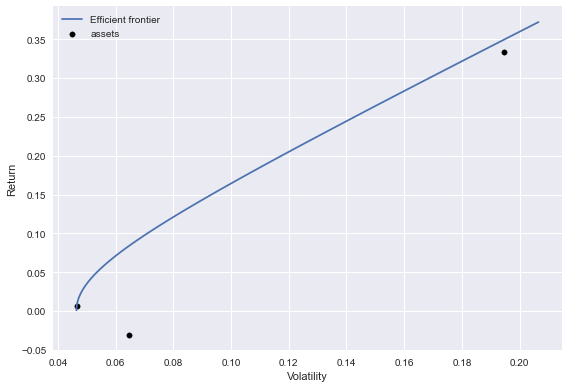

In [22]:
# Reference: https://pyportfolioopt.readthedocs.io/en/latest/
# Drawing the efficient frontier for the respective stocks we have in the portfolio

new_annualized_returns = new_stock_return.iloc[:, :stock_len+1].mean()*252

# Calculating the volatility which we'll need to plot the efficient frontier
volatility = new_stock_return.iloc[:, :stock_len+1].cov() * np.sqrt(252) # annualized covariance.

mu = new_annualized_returns
S = volatility
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

try:
    fig, ax = plt.subplots()
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
    plt.show()
except:
    print('The Efficient frontier cannot be plotted for the companies selected. Sorry for the inconvenience caused.')

### Evaluating the whole portfolio now:

In [23]:
# Reference: https://pyportfolioopt.readthedocs.io/en/latest/
# Calculating expected annual returns, annual volatility and sharpe ratio of our portfolio using library functions
# Optimize for maximal Sharpe ratio

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 33.4%
Annual volatility: 19.5%
Sharpe Ratio: 1.62


(0.3342850805225937, 0.19454319509847864, 1.6155028211780995)

In [24]:
if ef.portfolio_performance(verbose=False)[0]*100 >= exp_ret1:
    print('The portfolio gives an annual return of > '+str(exp_ret1)+'%, hence we would recommend investing in it.')
elif ef.portfolio_performance(verbose=False)[0]*100 < exp_ret1:
    print('The portfolio gives an annual return of < '+str(exp_ret1)+'%, hence the portfolio has moderate returns. You can proceed as you wish.')
else:
    print('The portfolio gives negative returns, we would highly recommend looking at a different set of companies.')

The portfolio gives an annual return of > 10%, hence we would recommend investing in it.


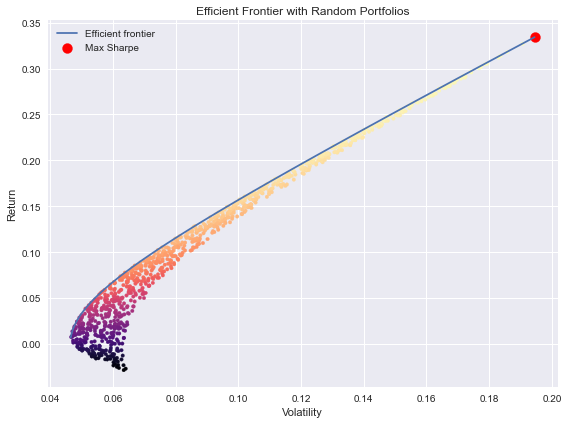

In [25]:
# Reference: https://medium.datadriveninvestor.com/easily-optimize-a-stock-portfolio-using-pyportfolioopt-in-python-80492b83912a
# Drawing the eficient frontier for our portfolio with 1000 other random portfolio values generated
# This shows how efficiently our portfolio can be managed to get the best returns

def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.01)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="r",     label="Max Sharpe")
# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="magma")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
try:
    plot_efficient_frontier_and_max_sharpe(mu, S)
except:
    print('The Efficient frontier cannot be plotted for the companies selected. Sorry for the inconvenience caused.')

In [26]:
# Reference: Notebooks provided in class for reference. '4.Portfolio Theory and Its Application in Python.ipynb'
# Calculating expected annual returns, annual volatility and sharpe ratio of our portfolio using custom functions

def get_opt(weights):
    weights = np.array(weights)
    ret = np.sum(new_stock_return.iloc[:, :len(returns.columns)].mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(new_stock_return.iloc[:, :len(returns.columns)].cov() * np.sqrt(252), weights)))
    sharpe = ret / vol
    return np.array([ret, vol, sharpe])

def neg_sharpe(weights):
    return get_opt(weights)[2] * -1

def const_sum(weights):
    return np.sum(weights)-1

cons = ({'type':'eq', 'fun':const_sum})
bound=(0, 1)
bounds = ((bound, )*stock_len)
init_guess = [0.33]*stock_len

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

print('Expected annual return: ' + str(get_opt(opt_results.x)[0]*100) + ' %')
print('Annual volatility: ' + str(get_opt(opt_results.x)[1]*100) + ' %')
print('Sharpe Ratio: ' + str(get_opt(opt_results.x)[2]))

# These are the annual returns, annual volatility and sharpe ratio of our portfolio

Expected annual return: 33.42850805225937 %
Annual volatility: 19.454319509847863 %
Sharpe Ratio: 1.718307753470262


In [27]:
if get_opt(opt_results.x)[0]*100 >= exp_ret1:
    print('The portfolio gives an annual return of > '+str(exp_ret1)+'%, hence we would recommend investing in it.')
elif get_opt(opt_results.x)[0]*100 < exp_ret1:
    print('The portfolio gives an annual return of < '+str(exp_ret1)+'%,, hence the portfolio has moderate returns. You can proceed as you wish.')
else:
    print('The portfolio gives negative returns, we would highly recommend looking at a different set of companies.')

The portfolio gives an annual return of > 10%, hence we would recommend investing in it.


In [30]:
if ef.portfolio_performance(verbose=False)[0]*100 >= exp_ret1 and get_opt(opt_results.x)[0]*100 >= exp_ret1:
    print('Both techniques show annual returns > '+str(exp_ret1)+'%. Hence we would highly recommend investing in these stocks! All the best!')
elif ef.portfolio_performance(verbose=False)[0]*100 <=0 and get_opt(opt_results.x)[0]*100 <= 0:
    print('Both techniques show terrible annual returns. Hence we would highly recommend not investing in these stocks!')
else:
    print('Please go through the analysis done above and proceed with caution.')
    
if ef.portfolio_performance(verbose=False)[1]*100 > exp_ret1 and get_opt(opt_results.x)[1]*100 > 10:
    print('\nBe cautious of volatility!')

Both techniques show annual returns > 10%. Hence we would highly recommend investing in these stocks! All the best!

Be cautious of volatility!
